In [50]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from  sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import SentenceTransformer
import os
from sentence_transformers import InputExample
import pandas as pd

In [51]:
subsets = [
  "all_languages",
  "ar",
  "de",
  "de-en",
  "de-fr",
  "de-pl",
  "en",
  "es",
  "es-en",
  "es-it",
  "fr",
  "fr-pl",
  "it",
  "pl",
  "pl-en",
  "ru",
  "tr",
  "zh",
  "zh-en"
]

sts22 = {}

for subset in subsets:
  sts22[subset] = load_dataset("mteb/sts22-crosslingual-sts", subset, split="test")

In [52]:
def createPlts(datasets, datasetKeys: list[str] , bins: list[int]):
  word_count = {}
  for i in datasetKeys:
    word_count[i] = [len(x.split()) for x in datasets[i]["sentence1"]]

  num_subplots = len(datasetKeys)
  num_cols = 7
  num_rows = num_subplots // num_cols + 1

  fig, axes = fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
  axes = axes.flatten()

  for idx, subset in enumerate(datasetKeys):
    data = word_count[subset]
    axes[idx].hist(data, bins=bins, edgecolor="black")
    axes[idx].set_title(subset)
    axes[idx].set_xlabel('Word count')
    axes[idx].set_ylabel('Frequency')

    counts, _ = np.histogram(data, bins=bins)
    max_count = max(counts)
    if max_count <= 50:
      axes[idx].set_ylim(0, 50)
    elif max_count <= 200:
      axes[idx].set_ylim(0, 200)
    elif max_count <= 500:
      axes[idx].set_ylim(0, 500)
    elif max_count <= 1000:
      axes[idx].set_ylim(0, 1000)
    else:
      axes[idx].set_ylim(0, 2000)

  for i in range(num_subplots, num_rows * num_cols):
    fig.delaxes(axes[i])

  plt.tight_layout()
  plt.show()

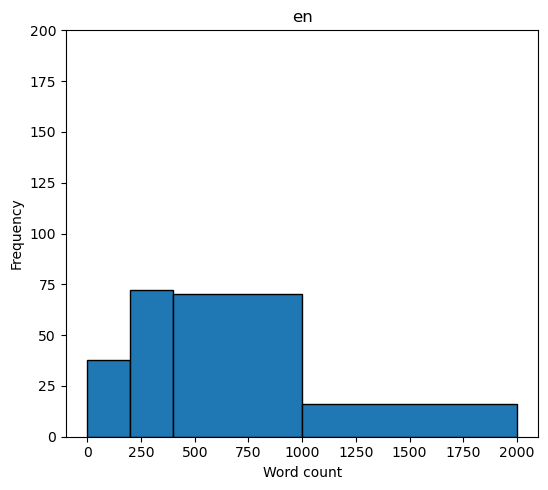

In [60]:
BINS = [0, 80, 200, 400, 1000, 2000]
SUBSETS = ["de"]
createPlts(sts22, SUBSETS, BINS)

In [61]:
samples = {}
for subset in SUBSETS:
    samples_subset = {}
    for idx in range(len(BINS)-1):
        key = f"{BINS[idx]}-{BINS[idx+1]}"
        samples_subset[key] = [InputExample(texts=[item["sentence1"], item["sentence2"]], label=item["score"]/5) for item in sts22[subset] if BINS[idx] <= len(item["sentence1"].split()) < BINS[idx+1]]   
    samples[subset] = samples_subset

In [62]:
samples

{'en': {'0-200': [<sentence_transformers.readers.InputExample.InputExample at 0x2995ba5d0>,
  '200-400': [<sentence_transformers.readers.InputExample.InputExample at 0x31f5b7950>,
  '400-1000': [<sentence_transformers.readers.InputExample.InputExample at 0x307f23a90>,
  '1000-2000': [<sentence_transformers.readers.InputExample.InputExample at 0x307f69e90>,
   <sentence_transformers.readers.InputExample.InputExample at 0x307f6a150>]}}

In [63]:
evaluators = {}

for subset in SUBSETS:
    evaluators_subset = {}
    samples_subset = samples[subset]
    for i in range(len(BINS)-1):
        key = f"{BINS[i]}-{BINS[i+1]}"
        evaluators_subset[key] = EmbeddingSimilarityEvaluator.from_input_examples(samples_subset[key], name=f"sts22-{key}")
    evaluators[subset] = evaluators_subset

In [64]:
evaluators

{'en': {'0-200': <sentence_transformers.evaluation.EmbeddingSimilarityEvaluator.EmbeddingSimilarityEvaluator at 0x307f6bbd0>,
  '200-400': <sentence_transformers.evaluation.EmbeddingSimilarityEvaluator.EmbeddingSimilarityEvaluator at 0x307f6bb90>,
  '400-1000': <sentence_transformers.evaluation.EmbeddingSimilarityEvaluator.EmbeddingSimilarityEvaluator at 0x307f69650>,
  '1000-2000': <sentence_transformers.evaluation.EmbeddingSimilarityEvaluator.EmbeddingSimilarityEvaluator at 0x307f69910>}}

In [65]:
models = [
  "sentence-transformers/gtr-t5-large"
]

for model_name in models:
  print("Evaluating model", model_name)
  model = SentenceTransformer(model_name)
  for subset in evaluators:
    print("Evaluating subset", subset)
    evaluators_subset = evaluators[subset]
    for key in evaluators_subset:
      print("Evaluating bin", key)
      evaluator = evaluators_subset[key]
      output_path = f"./results/sts22-{subset}/{model_name}/"
      os.makedirs(output_path, exist_ok=True)
      evaluator(model, output_path=output_path)

Evaluating model sentence-transformers/gtr-t5-large
Evaluating subset en
Evaluating bin 0-200
Evaluating bin 200-400


KeyboardInterrupt: 

In [66]:
for model_name in models:
  for subset in evaluators:
    file_paths = []
    extracted_data = {'Range': [], 'Cosine_Pearson': [], 'Sample Count': []}
    for key in evaluators[subset]:
      file_path = f"./results/sts22-{subset}/{model_name}/similarity_evaluation_sts22-{key}_results.csv"
      file_paths.append(file_path)

      df = pd.read_csv(file_path)
      cosine_pearson = df['cosine_pearson'].mean()
      extracted_data['Range'].append(key)
      extracted_data['Cosine_Pearson'].append(cosine_pearson)
      extracted_data['Sample Count'].append(len(samples[subset][key]))
    extracted_df = pd.DataFrame(extracted_data)
    print(extracted_df) 


       Range  Cosine_Pearson  Sample Count
0      0-200        0.496388            38
1    200-400        0.760514            72
2   400-1000        0.614951            70
3  1000-2000        0.512712            16
